In [1]:
#import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pandas as pd
import numba
import seaborn as sns
from IPython.display import display, clear_output
import time

In [2]:
#define date range
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2024, 9, 17)
years = (end - start).days / 365.25

In [3]:
#define starting variables
symbols = ["^GSPC"]
systems = ["RSI"]
starting_balance = 10000
slow_ma = 200
fast_ma = 5
rsi_periods = []
rsi_periods.extend(range(2, 22, 2))
rsi_thresholds = []
rsi_thresholds.extend(x / 10.0 for x in range(50, 425, 25)) # periods from 5 to 40 in 2.5 increments

In [4]:
def get_price_data(symbol):
    #download data
    price = yf.download(symbol, start, end, progress = False)
    
    #drop redundant columns
    price = price.drop(["Volume", "Adj Close"], axis=1)
    
    return price

In [5]:
# https://stackoverflow.com/questions/57006437/calculate-rsi-indicator-from-pandas-dataframe
def rma(x, n):
    #Running moving average
    a = np.full_like(x, np.nan)
    a[n] = x[1:n+1].mean()
    for i in range(n+1, len(x)):
        a[i] = (a[i-1] * (n - 1) + x[i]) / n
    return a

In [6]:
def calculate_inputs(df, s, rsi_period):
    #calculate inputs required for system
    
    #calculate moving averages
    df["Fast_MA"] = df.Close.rolling(window = fast_ma).mean()
    df["Slow_MA"] = df.Close.rolling(window = slow_ma).mean()
    
    #daily change
    df["Change"] = df.Close.diff()
    #separate into up and down days
    df["Gain"] = df.Change.clip(lower = 0)
    df["Loss"] = -1 * df.Change.clip(upper = 0)
    
    df[f"{s}Avg_Gain"] = rma(df.Gain.to_numpy(), rsi_period)
    df[f"{s}Avg_Loss"] = rma(df.Loss.to_numpy(), rsi_period)
    
    #relative strength
    df[f"{s}RS"] = df[f"{s}Avg_Gain"] / df[f"{s}Avg_Loss"]
    
    #RSI
    df[f"{s}RSI"] = 100 - (100 / (1 + df[f"{s}RS"]))
    
    return df

In [7]:
def generate_signals(df, s, rsi_thresh):
    #generate entries and exits
    if s == "BuyHold":
        df[f"{s}_Signal"] = True
    else:
        #entry is taken at the open. Signal is generated today based on yesterday's conditions
        df[f"{s}_Signal"] = (df[f"{s}RSI"].shift(1) < rsi_thresh) & (df.Close.shift(1) > df.Slow_MA.shift(1))

    #Connor exit strategy
    df[f"{s}_Exit"] = (df.Close > df.Fast_MA)
    
    return df

In [8]:
def generate_trades(df, s):
    if s == "BuyHold":
        #calculate benchmark return and balance
        df[f"{s}_Trade"] = True
        df[f"{s}_Ret"] = df.Close / df.Close.shift(1)
        df[f"{s}_Ret"].iat[0] = 1
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
        df[f"{s}_Running_Bal"] = df[f"{s}_Bal"]
        df[f"{s}_Entry_Price"] = df.Close
    else:
        #create empty list for trades
        trades_list = []
        trade_open = False
        open_change = {}
        
        #iterate through rows to work out entries and exits
        for i, row in df.iterrows():
            #if there is currently no trade
            if trade_open == False:
                #check if long signal was generated at the close and enter at the same time
                if row[f"{s}_Signal"] == True:
                    entry_date = i
                    entry_price = row.Open
                    trade_open = True
            #check if a trade is already open
            if trade_open == True:
                #check if an exit signal has been generated on today's close and sell shares
                if row[f"{s}_Exit"] == True:
                    exit_date = i
                    exit_price = row.Close
                    trade_open = False
                    #store trade data in a list
                    trade = [entry_date, entry_price, exit_date, exit_price, True]
                    #append trade to overall trade list
                    trades_list.append(trade)
                else:
                    #otherwise track the open change while the trade is open to monitor balance during the trade.
                    open_change[i] = row.Low / entry_price
                    
        trades = pd.DataFrame(trades_list, columns = ["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Sys_Trade"])
        
        #calculate return of each trade as well as the trade duration
        trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
        dur = []
        for i, row in trades.iterrows():
            d1 = row.Entry_Date
            d2 = row.Exit_Date
            dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
        
        trades[f"{s}_Duration"] = dur
    
        #create a new dataframe with an index of exit dfs
        returns = pd.DataFrame(index = trades.Exit_Date)
        #create a new dataframe with an index of entries to track entry price
        entries = pd.DataFrame(index = trades.Entry_Date)

        entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
        #add the Return column to this new data frame
        returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
        returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
        returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
        change_ser = pd.Series(open_change, name=f"{s}_Change")
    
        #add the returns from the trades to the main data frame
        df = pd.concat([df, returns, entries, change_ser], axis = 1)
        #fill all the NaN return values with 1 as there was no profit or loss on those days
        df[f"{s}_Ret"] = df[f"{s}_Ret"].astype("float").fillna(1)
        #fill all the NaN trade values with False as there was no trade on those days
        df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
        #fill all the NaN return values with 1 as there was no loss on those days
        df[f"{s}_Change"] = df[f"{s}_Change"].astype("float").fillna(1)
        
        #calculate system balance
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
        #calculate the running balance
        df[f"{s}_Running_Bal"] = df[f"{s}_Bal"] * df[f"{s}_Change"]
    
        active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
        df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
        #populate trades column based on duration
        for count, t in enumerate(active_trades):
            if t == True:
                dur = df[f"{s}_Duration"].iat[count]
                for i in range(int(dur)):
                    #starting from the exit date, move backwards and mark each trading day
                    df[f"{s}_In_Market"].iat[count - i] = True
    
    return df

In [9]:
def backtest(price, per, th):

    for s in systems:
        #calculate strategy inputs
        price = calculate_inputs(price, s, per)
        #generate signals
        price = generate_signals(price, s, th)
        #generate trades
        price = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]
        price[f"{s}_Running_DD"] = price[f"{s}_Running_Bal"] - price[f"{s}_Peak"]

    return price

In [10]:
#calculate metrics
def get_metrics(system, data):
    metrics = {}
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    sys_running_dd = round(((data[f"{system}_Running_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    periods_in_market = data[f"{system}_In_Market"].sum()
    
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    wins = win.sum()
    losses = loss.sum()
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    #make sure there are some trades to get metrics from
    if data[f"{system}_Entry_Price"].sum() > 0:
        rbe = round((sys_cagr / tim) * 100, 2)
        gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
        non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
        winrate = round(wins / (wins + losses) * 100, 2)
        #make sure there are losses to get loss metrics from
        if abs(sys_dd) > 0:
            rod = sys_cagr / abs(sys_dd)
            rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
        else:
            rod = 0
            rbeod = 0      
    else:
        rod = 0
        rbe = 0
        rbeod = 0
        gaps = 0
        non_gaps = 0
        winrate = 0
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    metrics["Time_in_Market"] = round(tim, 2)
    metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    metrics["Max_Running_Drawdown"] = round(sys_running_dd, 2)
    metrics["Return_Over_Drawdown"] = round(rod, 2)
    metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    metrics["Gap"] = round(gaps)
    metrics["No_Gap"] = round(non_gaps)
    metrics["Wins"] = round(wins, 2)
    metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr
    
    return metrics

In [11]:
results = []
prog = 0
max_prog = len(symbols) * len(rsi_periods) * len(rsi_thresholds)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for per in rsi_periods:
        for th in rsi_thresholds:
            result = backtest(price, per, th)
            results.append(result)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 55.118831634521484 s


In [12]:
full_metrics = {}
for count, res in enumerate(results):
    sys_metrics = {}
    for s in systems:
        sys_metrics.update({s: get_metrics(s, res)})
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)
    full_metrics.update({count: sys_metrics_df})

In [13]:
compared_metrics = pd.DataFrame(columns=["sys", "cagr", "tim", "rbe", "max_dd", "rod", "rbeod", "winrate", "rr"])
count = 0
for per in rsi_periods:
    for th in rsi_thresholds:
        data = full_metrics[count]
        sys = f"RSI_Period_{per}_Thresh{th}"
        cagr = data[systems[0]].loc["Annual_Return"]
        tim = data[systems[0]].loc["Time_in_Market"]
        rbe = data[systems[0]].loc["Return_By_Exposure"]
        max_dd = data[systems[0]].loc["Max_Drawdown"]
        rod = data[systems[0]].loc["Return_Over_Drawdown"]
        rbeod = data[systems[0]].loc["RBE_Over_Drawdown"]
        winrate = data[systems[0]].loc["Winrate"]
        rr = data[systems[0]].loc["Avg_RR"]
        new_row = [sys, cagr, tim, rbe, max_dd, rod, rbeod, winrate, rr]
        compared_metrics.loc[len(compared_metrics)] = new_row
        count += 1

In [14]:
#pd.set_option('display.max_rows', None)
compared_metrics

,sys,cagr,tim,rbe,max_dd,rod,rbeod,winrate,rr
0,RSI_Period_2_Thresh5.0,2.78,5.82,47.77,-11.81,0.24,4.04,81.51,0.74
1,RSI_Period_2_Thresh7.5,3.97,8.42,47.15,-11.81,0.34,3.99,78.34,0.91
2,RSI_Period_2_Thresh10.0,4.11,11.29,36.40,-11.08,0.37,3.29,75.36,0.88
3,RSI_Period_2_Thresh12.5,4.14,14.01,29.55,-12.71,0.33,2.32,74.63,0.78
4,RSI_Period_2_Thresh15.0,4.65,16.34,28.46,-10.37,0.45,2.74,74.13,0.79
5,RSI_Period_2_Thresh17.5,4.72,18.44,25.60,-10.37,0.46,2.47,74.01,0.75
6,RSI_Period_2_Thresh20.0,4.92,19.83,24.81,-10.83,0.45,2.29,74.85,0.68
7,RSI_Period_2_Thresh22.5,5.14,21.39,24.03,-11.81,0.44,2.03,75.00,0.66
8,RSI_Period_2_Thresh25.0,5.18,22.93,22.59,-10.33,0.50,2.19,74.44,0.66
9,RSI_Period_2_Thresh27.5,4.82,24.60,19.59,-12.53,0.38,1.56,73.03,0.66


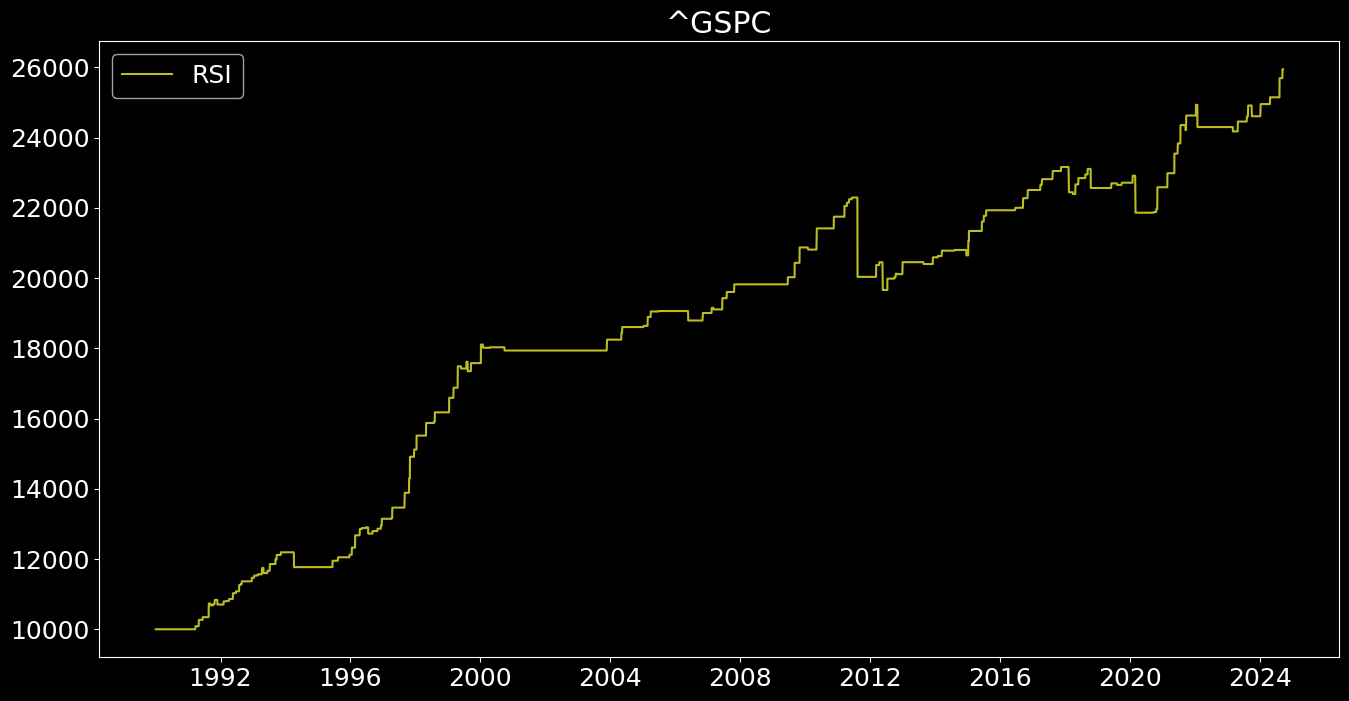

In [15]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams.update({"font.size": 18})

colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange"]

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(sym)
    for c, s in enumerate(systems):
        plt.plot(results[count][f"{s}_Bal"], colours[c])

plt.legend(systems)
plt.show()

In [17]:
cagrs_full = []
count = 0
for per in rsi_periods:
    cagrs = []
    for th in rsi_thresholds:
        cagrs.append(full_metrics[count]["RSI"].at["Annual_Return"])
        count += 1
    cagrs_full.append(cagrs)

In [18]:
rbes_full = []
count = 0
for per in rsi_periods:
    rbes = []
    for th in rsi_thresholds:
        if full_metrics[count]["RSI"].at["Time_in_Market"] > 2.5:
            rbes.append(full_metrics[count]["RSI"].at["Return_By_Exposure"])
        else:
            rbes.append(0)
        count += 1
    rbes_full.append(rbes)

In [16]:
rbeod_full = []
count = 0
for per in rsi_periods:
    rbeod = []
    for th in rsi_thresholds:
        if full_metrics[count]["RSI"].at["Time_in_Market"] > 2.5:
            rbeod.append(full_metrics[count]["RSI"].at["RBE_Over_Drawdown"])
        else:
            rbeod.append(0)
        count += 1
    rbeod_full.append(rbeod)

[Text(0.5, 36.72222222222221, 'Thresholds'),
 Text(120.72222222222221, 0.5, 'RSI Period')]

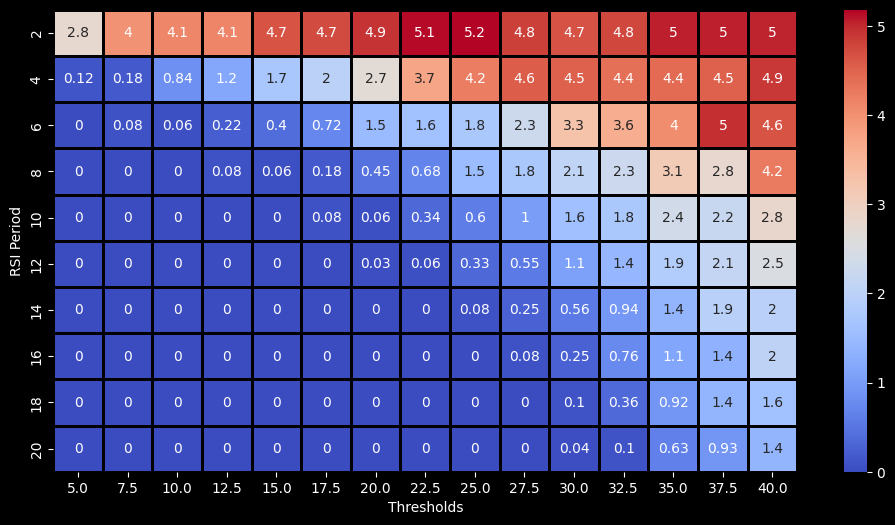

In [22]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(cagrs_full,
            cmap="coolwarm",
            xticklabels=rsi_thresholds,
            yticklabels=rsi_periods,
            linewidth=1,
            linecolor="black",
            annot=True
           )
ax.set(xlabel="Thresholds", ylabel="RSI Period")

[Text(0.5, 26.722222222222207, 'Thresholds'),
 Text(110.72222222222221, 0.5, 'RSI Period')]

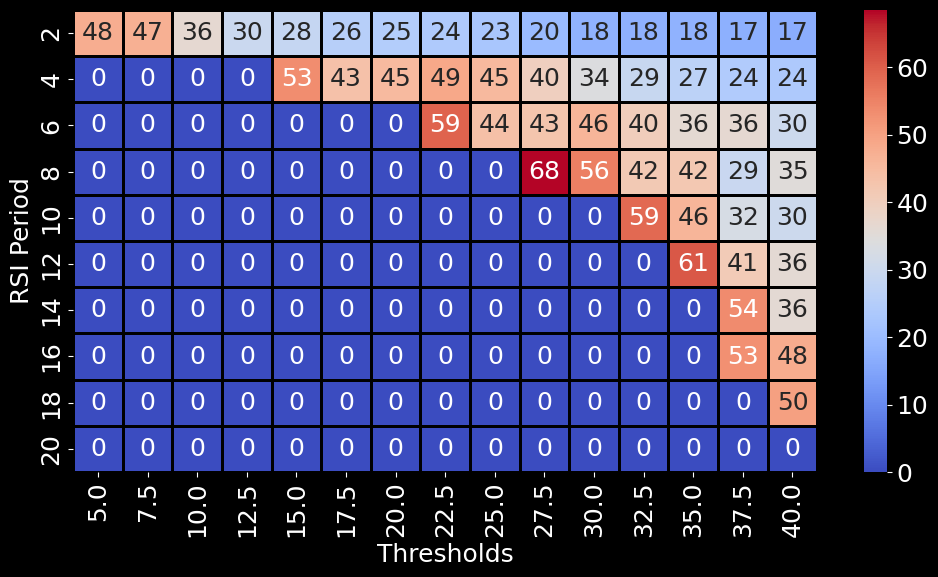

In [19]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(rbes_full,
            cmap="coolwarm",
            xticklabels=rsi_thresholds,
            yticklabels=rsi_periods,
            linewidth=1,
            linecolor="black",
            annot=True
           )
ax.set(xlabel="Thresholds", ylabel="RSI Period")

[Text(0.5, 26.722222222222207, 'Thresholds'),
 Text(110.72222222222221, 0.5, 'RSI Period')]

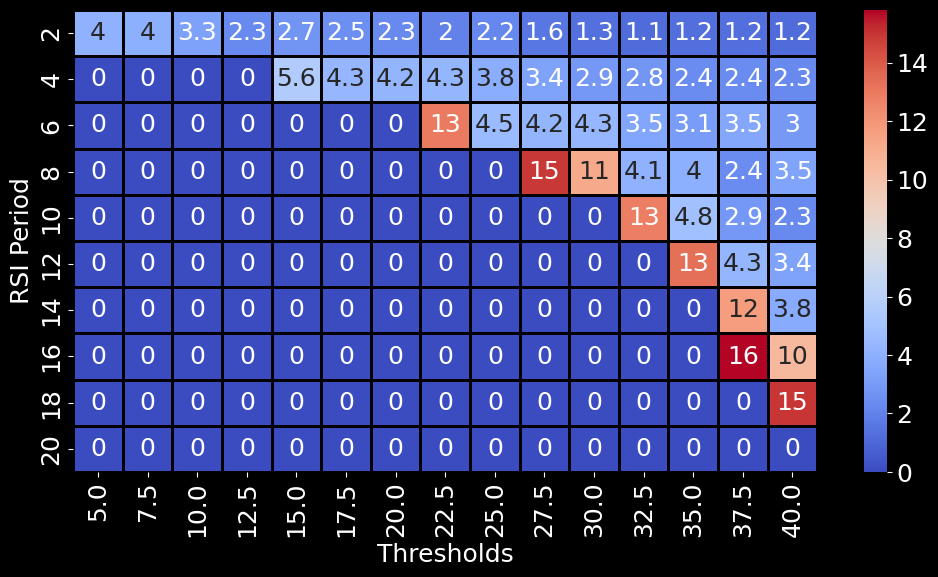

In [20]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(rbeod_full,
            cmap="coolwarm",
            xticklabels=rsi_thresholds,
            yticklabels=rsi_periods,
            linewidth=1,
            linecolor="black",
            annot=True
           )
ax.set(xlabel="Thresholds", ylabel="RSI Period")